# Feature Engineering for Bikesharing Data

Some aims & notes:

- Need to de-trend/de-season data, since we saw a gradual overall rise in ridership as the bikeshare programme became more established.
- Categorical difference between day type (holiday, working day) is important
- Weather factors also important
- Collapse across registered/casual ridership (as we need to predict the number of bikes that need to be made available for hire, which is agnostic as to which rider type the bikes are rented by)

## Step 0: import packages and data

In [83]:
import pandas as pd
import numpy as np

from statsmodels.api import OLS, add_constant

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import RFE

from sklearn.dummy import DummyRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures

from sklearn.impute import SimpleImputer

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

from sklearn.decomposition import PCA

from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline

In [73]:
df_raw = pd.read_csv('./data/train_bike_engineered.csv')

## Step 1: Determining how to deal with time series information

### a. Identifying time trends

Question: Is time a factor in bike counts? If so, we need to take this into account.

Start by fitting linear and quadratic timesteps to the original data. 

In [74]:
# get datetime info into index, sort by index

df_raw.set_index('datetime', inplace=True)
df_raw.sort_index(inplace=True)

In [75]:
df_raw['timestep'] = np.arange(1, len(df)+1)
df_raw['quad_timestep'] = np.arange(1, len(df)+1)**2

In [76]:
time_X = add_constant(df_raw['timestep'])
time_Xsq = add_constant(df_raw[['timestep', 'quad_timestep']])

In [77]:
time_y = df_raw['count']

In [78]:
time_model_linear = OLS(time_y, time_X)

In [79]:
time_result_linear = time_model_linear.fit()
time_result_linear.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.097
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     1164.
Date:                Wed, 06 Jan 2021   Prob (F-statistic):          1.92e-242
Time:                        17:50:18   Log-Likelihood:                -71493.
No. Observations:               10886   AIC:                         1.430e+05
Df Residuals:                   10884   BIC:                         1.430e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         94.0527      3.301     28.495      0.000      87.583     100.523
timestep       0.0179      0.001     34.115      0.000       0.017       0.019
==============================================================================
Omnibus:                     1483.704   Durbin-Watson:                   0.350
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2214.344
Skew:                           1.000   Prob(JB):                         0.00
Kurtosis:                       3.941   Cond. No.                     1.26e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [80]:
time_model_quad = OLS(time_y, time_Xsq)

In [81]:
time_result_quad = time_model_quad.fit()
time_result_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.099
Model:                            OLS   Adj. R-squared:                  0.099
Method:                 Least Squares   F-statistic:                     600.3
Date:                Wed, 06 Jan 2021   Prob (F-statistic):          4.82e-248
Time:                        17:50:22   Log-Likelihood:                -71476.
No. Observations:               10886   AIC:                         1.430e+05
Df Residuals:                   10883   BIC:                         1.430e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            72.7675      4.944     14.717      0.000      63.076      82.459
timestep          0.0296      0.002     14.133      0.000       0.026       0.034
quad_timestep -1.077e-06   1.87e-07     -5.775      0.000   -1.44e-06   -7.12e-07
==============================================================================
Omnibus:                     1482.486   Durbin-Watson:                   0.351
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2213.946
Skew:                           0.998   Prob(JB):                         0.00
Kurtosis:                       3.947   Cond. No.                     1.59e+08
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.59e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**Outcome:**

Looking at F-statistic, looks like the linear trend has higher explanatory power -- let's go with a linear trend & remove this from the count data.

Use differenced version of `count` as basis for further work.

In [90]:
df_raw['differenced'] = df_raw['count'].diff()

In [96]:
df_raw['second_order_diff'] = df_raw['differenced'].diff()

### b. Dealing with seasonality

Let's plot the volatility by looking at percent changes in count from hour to hour.

Outcome: it looks like there's quite a bit of seasonality -- I'll smoothe this out by subtracting the daily mean from each count.

In [103]:
df_raw['percentage_change'] = df_raw['differenced'].pct_change()

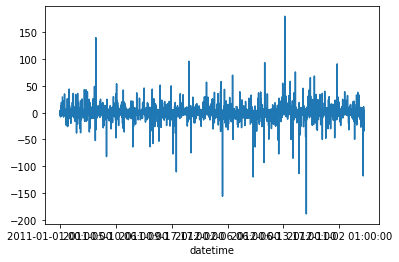

In [104]:
df_raw['percentage_change'].plot()

In [105]:
df_raw['daily_mean'] = df_raw.groupby('date')['percentage_change'].transform('mean')

In [106]:
df_raw['deseasoned_count'] = df_raw['differenced'] - df_raw['daily_mean']

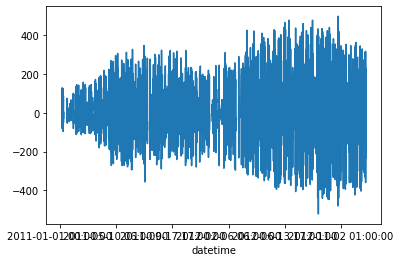

In [107]:
df_raw['deseasoned_count'].plot()

## Step 1: train-test split

Splitting at this stage to ensure no contamination of test data.

In [17]:
y = df_raw['count']

X = df_raw.drop(['count', 'registered', 'casual'], axis = 1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

Xtrain.shape, Xtest.shape, ytrain.shape, ytest.shape

((8164, 16), (2722, 16), (8164,), (2722,))

In [18]:
X.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'temp_bins', 'atemp_bins',
       'wind_bins', 'hour', 'date', 'month', 'year'],
      dtype='object')